# Drive'ınıza Bağlanmanızı Sağlar

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


# Kütüphanenize Gerekli Olan Yapıların Eklenmesini Sağlar

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import numpy as np
import math
import time
import os
import cv2

# Datasetimize Erişmek İçin Gerekli Olan Yolları Tanımlıyoruz

In [34]:
torch.cuda.empty_cache()
INPUT_PATH = os.getcwd()+'/YeniDataset/Dataset/seperated/'
OUTPUT_PATH = os.getcwd()+'/YeniDataset/Dataset/'

# paths

train_path = INPUT_PATH + 'training/'
#full_train_path = data_path + '/train_full/'
valid_path = INPUT_PATH  + 'testing/'
test_path = INPUT_PATH  + 'mini/'



In [ ]:
test_path

'/content/drive/MyDrive/YeniDataset/Dataset/seperated/mini/'

# Training Ve Testingde Bulunan Resimleri Saydırıyoruz

In [ ]:
_, _, files = next(os.walk(train_path +"covid"))
train_count_c = len(files)
print("train_c size:",train_count_c)
_, _, files = next(os.walk(train_path +"normal"))
train_count_n = len(files)
print("train_n size:",train_count_n)
_, _, files = next(os.walk(valid_path +"normal"))
test_count_n = len(files)
print("valid_n size:",test_count_n)
_, _, files = next(os.walk(valid_path +"covid"))
test_count_c = len(files)
print("valid_c size:",test_count_c)


train_c size: 3500
train_n size: 3500
valid_n size: 938
valid_c size: 962


# Test Datamızı Saydırıyoruz

In [ ]:
_, _, files = next(os.walk(test_path +"covid"))
train_count = len(files)
print("test size:",train_count)

test size: 100


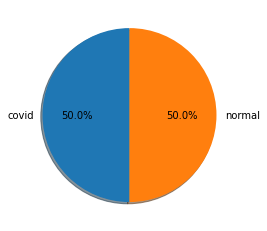

In [ ]:
class_names = os.listdir(train_path)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(train_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

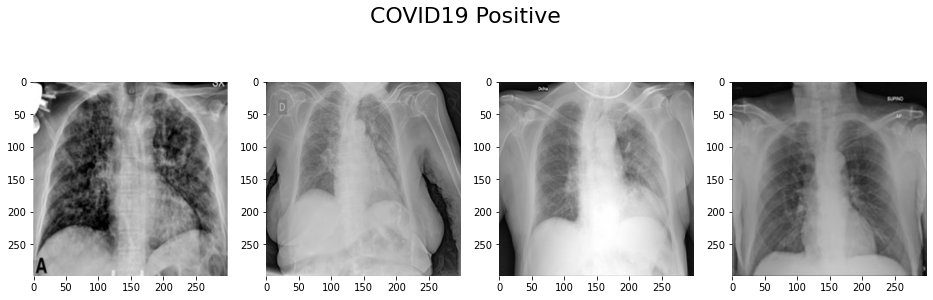

In [ ]:
from random import shuffle
import cv2
COVID_PATH=train_path +"covid"
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

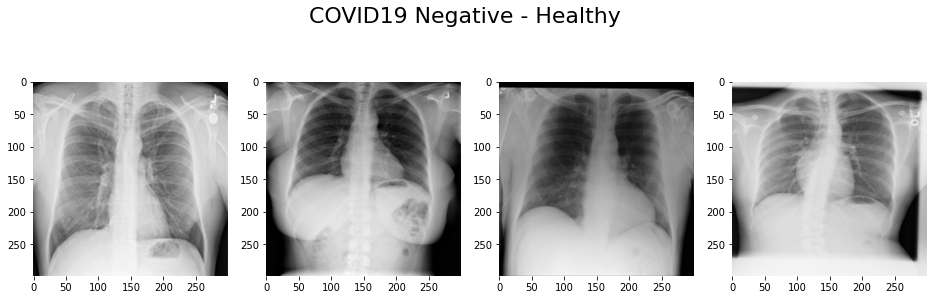

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
NORMAL_PATH=train_path +"normal"
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

TRANSFORM = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)])

In [ ]:
batch_size = 100
train_loader = data.DataLoader(
               datasets.ImageFolder(train_path,TRANSFORM),
               batch_size=batch_size,
               shuffle=True,
               num_workers=4)
val_loader  =  data.DataLoader(
               datasets.ImageFolder(valid_path,TRANSFORM),
               batch_size=batch_size,
               shuffle=True,
               num_workers=4)
test_loader  =  data.DataLoader(
               datasets.ImageFolder(test_path,TRANSFORM),
               shuffle=True,
               num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [19]:
net=Cnn().to(device)
net.train()
optimizer = optim.Adam(params = net.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(net.parameters(), lr=LR, alpha=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


#criterion.to(device)


In [ ]:
net

In [20]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = net(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
   #print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = net(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch :{},train_acc : %{:.2f}, train_loss :{:.4f}, val_acc :%{:.2f}, val_loss:{:.4f}'.format(epoch+1,epoch_accuracy*100,epoch_loss, epoch_val_accuracy*100,epoch_val_loss))

Epoch :1,train_acc : %66.93, train_loss :0.6011, val_acc :%70.32, val_loss:0.5527
Epoch :2,train_acc : %73.10, train_loss :0.5246, val_acc :%75.58, val_loss:0.4955
Epoch :3,train_acc : %75.66, train_loss :0.4839, val_acc :%79.00, val_loss:0.4553
Epoch :4,train_acc : %77.69, train_loss :0.4639, val_acc :%77.84, val_loss:0.4504
Epoch :5,train_acc : %78.67, train_loss :0.4419, val_acc :%78.84, val_loss:0.4340
Epoch :6,train_acc : %79.83, train_loss :0.4300, val_acc :%78.89, val_loss:0.4313
Epoch :7,train_acc : %81.00, train_loss :0.4083, val_acc :%78.53, val_loss:0.4327
Epoch :8,train_acc : %81.43, train_loss :0.3979, val_acc :%81.74, val_loss:0.3825
Epoch :9,train_acc : %82.76, train_loss :0.3752, val_acc :%82.21, val_loss:0.3705
Epoch :10,train_acc : %82.66, train_loss :0.3688, val_acc :%81.53, val_loss:0.3825


In [21]:
def pre_image(image_path):
   img = cv2.imread(image_path)
   #img2=img.reshape(3,299,299)
   #img2=np.asarray(img)
 
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   #tr=transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])
   tr = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((224,224)),transforms.Normalize(mean, std)])
   # get normalized image
   img2 = tr(img)
   print(img2.shape)
   img2=img2.reshape(1,3,224,224)
   
   #img_normalized = img_normalized.unsqueeze_(0)
   #input = Variable(image_tensor)
   #img2 = img2.to(device)
   #print(img2.shape)
   return img2


In [ ]:
image_path = test_path
image_path

'/content/drive/MyDrive/YeniDataset/Dataset/seperated/mini/'

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


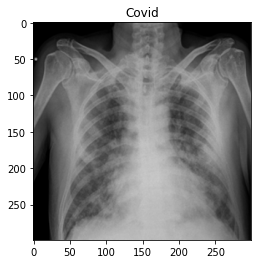

In [36]:
image_path = test_path +"covid/COVID-1056.png"
#image_path = test_path +"normal/Normal-1010.png"
#image_path = test_path +"johnny.png"
img=cv2.imread(image_path)
predict_class=5
im2=pre_image(image_path)
print(im2.shape)
im2=im2.to(device)
with torch.no_grad():
    pred = net(im2)
 #   loss = criterion(pred, 1.0)
sonuc=pred.argmax()
if(sonuc==0):
    plt.title("Covid")
else:
    plt.title("Normal")

plt.imshow(img)

covid_probs = []
net.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = net(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        covid_probs += list(zip(list(fileid), preds_list))

[ 0.2230, -1.4513  covid

[-1.8674, -0.2591 normal

[-1.5884,  0.0792


In [ ]:
%cd /content/drive/MyDrive/YeniDataset/Kayıtlılar

/content/drive/MyDrive/YeniDataset/Kayıtlılar


In [ ]:
import torch
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.ipynb')